# Connect to drive

### Run the cells below one by one!

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122550 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


# Import libraries & Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Convolution2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import random
import shutil
import cv2
import os
from PIL import Image

In [ ]:
ROOT_PATH = "./content/drive/MyDrive/CapstoneProject/ML"
DATASET_PATH = f"{ROOT_PATH}/Dataset/data"
TRAINING_PATH = f"{DATASET_PATH}/training4"
VALIDATION_PATH = f"{DATASET_PATH}/validation4"

In [ ]:
IMAGE_WIDTH = 500
IMAGE_HEIGHT = 889
IMAGE_SIZE=(IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3

In [ ]:
classes = ['empty_bunch', 'overripe', 'ripe', 'rotten', 'underripe', 'unripe']

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=IMAGE_SIZE)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='categorical',
                                                                target_size=IMAGE_SIZE)

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_PATH, VALIDATION_PATH)

Found 728 images belonging to 6 classes.
Found 186 images belonging to 6 classes.


# Create Model

In [ ]:
def simple_model():

  classifier = Sequential()

  # Step 1 - Convolution
  classifier.add(Convolution2D(64, 3, 3, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), activation = 'relu'))
  classifier.add(Dropout(0.2))
  classifier.add(MaxPooling2D(pool_size = (2, 2)))

  # Step 2 - Convolution
  classifier.add(Convolution2D(128, 3, 3, activation = 'relu'))
  classifier.add(Dropout(0.2))
  classifier.add(MaxPooling2D(pool_size = (2, 2)))

  # Step 3 - Convolution
  classifier.add(Convolution2D(256, 3, 3, activation = 'relu'))
  classifier.add(Dropout(0.2))
  classifier.add(MaxPooling2D(pool_size = (2, 2)))

  # Step 3 - Flattening
  classifier.add(Flatten())

  # Step 4 - Full connection
  classifier.add(Dense(128, activation = 'relu'))
  classifier.add(Dense(6, activation='softmax', kernel_initializer='he_normal'))

  return classifier

In [ ]:
from tensorflow.keras import backend as K

# Create custome recall, precision, and f1 function
# as model matrics to monitor

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Create csvlogger to save model history

from keras.callbacks import CSVLogger

LOGGER_PATH = f"{ROOT_PATH}/Dataset/model_checkpoints/best_model5_simple_augmented/training.log"
csv_logger = CSVLogger('LOGGER_PATH', separator=',', append=False)

In [ ]:
def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=30, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min')
  return estop

earlystop = earlystop('acc')

CHECKPOINT_PATH = f"{ROOT_PATH}/Dataset/model_checkpoints/best_model5_simple_augmented/best_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                            save_best_only=True, monitor='val_loss', mode="min")

In [ ]:
classifier = simple_model()
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 296, 166, 64)      1792      
                                                                 
 dropout_6 (Dropout)         (None, 296, 166, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 148, 83, 64)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 49, 27, 128)       73856     
                                                                 
 dropout_7 (Dropout)         (None, 49, 27, 128)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 13, 128)      0         
 2D)                                                  

In [ ]:
classifier.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc', f1_m])

# Train the model

In [ ]:
batch_size = 20
steps_per_epoch = 120/batch_size
validation_steps = 40/batch_size
classifier_history = classifier.fit(train_generator,
                                    epochs=200,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps,
                                    validation_data=validation_generator,
                                    shuffle=True,
                                    callbacks=[checkpoint, csv_logger])

Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: 1.8075 - acc: 0.1917 - f1_m: 0.0000e+00

6/6 [==============================] - 90s 17s/step - loss: 1.8075 - acc: 0.1917 - f1_m: 0.0000e+00 - val_loss: 1.7633 - val_acc: 0.2500 - val_f1_m: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 55s 9s/step - loss: 1.7551 - acc: 0.2000 - f1_m: 0.0000e+00 - val_loss: 1.7827 - val_acc: 0.1750 - val_f1_m: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 46s 8s/step - loss: 1.7948 - acc: 0.1481 - f1_m: 0.0000e+00 - val_loss: 1.7651 - val_acc: 0.1750 - val_f1_m: 0.0000e+00
Epoch 4/200
6/6 [==============================] - ETA: 0s - loss: 1.7446 - acc: 0.2250 - f1_m: 0.0000e+00

6/6 [==============================] - 87s 16s/step - loss: 1.7446 - acc: 0.2250 - f1_m: 0.0000e+00 - val_loss: 1.7562 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 36s 5s/step - loss: 1.7630 - acc: 0.1667 - f1_m: 0.0000e+00 - val_loss: 1.7595 - val_acc: 0.2500 - val_f1_m: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 35s 6s/step - loss: 1.7403 - acc: 0.1500 - f1_m: 0.0000e+00 - val_loss: 1.7860 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 7/200
6/6 [==============================] - ETA: 0s - loss: 1.8125 - acc: 0.1296 - f1_m: 0.0000e+00

6/6 [==============================] - 56s 10s/step - loss: 1.8125 - acc: 0.1296 - f1_m: 0.0000e+00 - val_loss: 1.7439 - val_acc: 0.3250 - val_f1_m: 0.0000e+00
Epoch 8/200
6/6 [==============================] - 22s 4s/step - loss: 1.7780 - acc: 0.1667 - f1_m: 0.0000e+00 - val_loss: 1.7447 - val_acc: 0.2500 - val_f1_m: 0.0000e+00
Epoch 9/200
6/6 [==============================] - ETA: 0s - loss: 1.7344 - acc: 0.2000 - f1_m: 0.0000e+00

6/6 [==============================] - 54s 10s/step - loss: 1.7344 - acc: 0.2000 - f1_m: 0.0000e+00 - val_loss: 1.7205 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 10/200
6/6 [==============================] - 23s 4s/step - loss: 1.7158 - acc: 0.1750 - f1_m: 0.0000e+00 - val_loss: 1.7801 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 11/200
6/6 [==============================] - 28s 4s/step - loss: 1.7172 - acc: 0.2333 - f1_m: 0.0000e+00 - val_loss: 1.7259 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 12/200
6/6 [==============================] - ETA: 0s - loss: 1.7407 - acc: 0.2250 - f1_m: 0.0000e+00

6/6 [==============================] - 51s 10s/step - loss: 1.7407 - acc: 0.2250 - f1_m: 0.0000e+00 - val_loss: 1.6687 - val_acc: 0.3250 - val_f1_m: 0.0000e+00
Epoch 13/200
6/6 [==============================] - ETA: 0s - loss: 1.6552 - acc: 0.2500 - f1_m: 0.0000e+00

6/6 [==============================] - 50s 9s/step - loss: 1.6552 - acc: 0.2500 - f1_m: 0.0000e+00 - val_loss: 1.6277 - val_acc: 0.4250 - val_f1_m: 0.0000e+00
Epoch 14/200
6/6 [==============================] - 16s 3s/step - loss: 1.6498 - acc: 0.3083 - f1_m: 0.0000e+00 - val_loss: 1.6989 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 15/200
6/6 [==============================] - 18s 3s/step - loss: 1.6592 - acc: 0.2315 - f1_m: 0.0000e+00 - val_loss: 1.6706 - val_acc: 0.2000 - val_f1_m: 0.0000e+00
Epoch 16/200
6/6 [==============================] - 19s 3s/step - loss: 1.6926 - acc: 0.2750 - f1_m: 0.0000e+00 - val_loss: 1.6808 - val_acc: 0.2500 - val_f1_m: 0.0000e+00
Epoch 17/200
6/6 [==============================] - ETA: 0s - loss: 1.6779 - acc: 0.2870 - f1_m: 0.0000e+00

6/6 [==============================] - 46s 9s/step - loss: 1.6779 - acc: 0.2870 - f1_m: 0.0000e+00 - val_loss: 1.6034 - val_acc: 0.2250 - val_f1_m: 0.0000e+00
Epoch 18/200
6/6 [==============================] - 18s 3s/step - loss: 1.6533 - acc: 0.2083 - f1_m: 0.0000e+00 - val_loss: 1.6318 - val_acc: 0.3000 - val_f1_m: 0.0000e+00
Epoch 19/200
6/6 [==============================] - ETA: 0s - loss: 1.6480 - acc: 0.3519 - f1_m: 0.0000e+00

6/6 [==============================] - 44s 9s/step - loss: 1.6480 - acc: 0.3519 - f1_m: 0.0000e+00 - val_loss: 1.5579 - val_acc: 0.5000 - val_f1_m: 0.0000e+00
Epoch 20/200
6/6 [==============================] - ETA: 0s - loss: 1.6282 - acc: 0.2870 - f1_m: 0.0278    

6/6 [==============================] - 45s 8s/step - loss: 1.6282 - acc: 0.2870 - f1_m: 0.0278 - val_loss: 1.5455 - val_acc: 0.3250 - val_f1_m: 0.0000e+00
Epoch 21/200
6/6 [==============================] - ETA: 0s - loss: 1.6226 - acc: 0.2778 - f1_m: 0.0807

6/6 [==============================] - 48s 9s/step - loss: 1.6226 - acc: 0.2778 - f1_m: 0.0807 - val_loss: 1.5341 - val_acc: 0.3000 - val_f1_m: 0.0000e+00
Epoch 22/200
6/6 [==============================] - ETA: 0s - loss: 1.4604 - acc: 0.3426 - f1_m: 0.0855

6/6 [==============================] - 67s 13s/step - loss: 1.4604 - acc: 0.3426 - f1_m: 0.0855 - val_loss: 1.4645 - val_acc: 0.3500 - val_f1_m: 0.0000e+00
Epoch 23/200
6/6 [==============================] - ETA: 0s - loss: 1.5037 - acc: 0.3083 - f1_m: 0.1101

6/6 [==============================] - 51s 10s/step - loss: 1.5037 - acc: 0.3083 - f1_m: 0.1101 - val_loss: 1.3371 - val_acc: 0.5000 - val_f1_m: 0.0000e+00
Epoch 24/200
6/6 [==============================] - 14s 2s/step - loss: 1.4513 - acc: 0.3083 - f1_m: 0.0903 - val_loss: 1.3896 - val_acc: 0.4250 - val_f1_m: 0.0000e+00
Epoch 25/200
6/6 [==============================] - 15s 2s/step - loss: 1.4968 - acc: 0.3056 - f1_m: 0.0152 - val_loss: 1.3772 - val_acc: 0.4000 - val_f1_m: 0.1385
Epoch 26/200
6/6 [==============================] - 15s 3s/step - loss: 1.4814 - acc: 0.3333 - f1_m: 0.0999 - val_loss: 1.5327 - val_acc: 0.3750 - val_f1_m: 0.0000e+00
Epoch 27/200
6/6 [==============================] - 16s 3s/step - loss: 1.5529 - acc: 0.3500 - f1_m: 0.0000e+00 - val_loss: 1.5131 - val_acc: 0.3250 - val_f1_m: 0.0000e+00
Epoch 28/200
6/6 [==============================] - 17s 3s/step - loss: 1.6129 - acc: 0.3000 - f1_m: 0.0303 - val_loss: 1.4699 - val_acc: 0.4250 - val_f1_m: 0.0000e+00
Epoc

6/6 [==============================] - 47s 9s/step - loss: 1.4493 - acc: 0.4000 - f1_m: 0.1070 - val_loss: 1.2914 - val_acc: 0.4500 - val_f1_m: 0.1726
Epoch 33/200
6/6 [==============================] - 15s 2s/step - loss: 1.3900 - acc: 0.4259 - f1_m: 0.2173 - val_loss: 1.3628 - val_acc: 0.3500 - val_f1_m: 0.1779
Epoch 34/200
6/6 [==============================] - 14s 2s/step - loss: 1.2904 - acc: 0.4259 - f1_m: 0.1259 - val_loss: 1.3528 - val_acc: 0.4250 - val_f1_m: 0.0476
Epoch 35/200
6/6 [==============================] - 15s 2s/step - loss: 1.4959 - acc: 0.3000 - f1_m: 0.1623 - val_loss: 1.3827 - val_acc: 0.3750 - val_f1_m: 0.0000e+00
Epoch 36/200
6/6 [==============================] - ETA: 0s - loss: 1.3972 - acc: 0.4167 - f1_m: 0.0889

6/6 [==============================] - 46s 9s/step - loss: 1.3972 - acc: 0.4167 - f1_m: 0.0889 - val_loss: 1.2870 - val_acc: 0.5750 - val_f1_m: 0.0952
Epoch 37/200
6/6 [==============================] - 17s 3s/step - loss: 1.3620 - acc: 0.3833 - f1_m: 0.1953 - val_loss: 1.3349 - val_acc: 0.4250 - val_f1_m: 0.2120
Epoch 38/200
6/6 [==============================] - 15s 3s/step - loss: 1.3047 - acc: 0.4500 - f1_m: 0.2389 - val_loss: 1.3157 - val_acc: 0.4000 - val_f1_m: 0.1385
Epoch 39/200
6/6 [==============================] - 16s 3s/step - loss: 1.3551 - acc: 0.4333 - f1_m: 0.2440 - val_loss: 1.3623 - val_acc: 0.4500 - val_f1_m: 0.0000e+00
Epoch 40/200
6/6 [==============================] - 15s 3s/step - loss: 1.3476 - acc: 0.4167 - f1_m: 0.3008 - val_loss: 1.4079 - val_acc: 0.3750 - val_f1_m: 0.1600
Epoch 41/200
6/6 [==============================] - 15s 3s/step - loss: 1.2756 - acc: 0.4417 - f1_m: 0.2765 - val_loss: 1.3727 - val_acc: 0.3250 - val_f1_m: 0.2159
Epoch 42/200
6/6 [=======

6/6 [==============================] - 47s 9s/step - loss: 1.3518 - acc: 0.3250 - f1_m: 0.1687 - val_loss: 1.2621 - val_acc: 0.5250 - val_f1_m: 0.0476
Epoch 43/200
6/6 [==============================] - ETA: 0s - loss: 1.3048 - acc: 0.4583 - f1_m: 0.2430

6/6 [==============================] - 51s 10s/step - loss: 1.3048 - acc: 0.4583 - f1_m: 0.2430 - val_loss: 1.1911 - val_acc: 0.4000 - val_f1_m: 0.2850
Epoch 44/200
6/6 [==============================] - 16s 3s/step - loss: 1.4046 - acc: 0.3833 - f1_m: 0.1838 - val_loss: 1.3132 - val_acc: 0.5250 - val_f1_m: 0.0952
Epoch 45/200
6/6 [==============================] - 15s 3s/step - loss: 1.2992 - acc: 0.4250 - f1_m: 0.2097 - val_loss: 1.3682 - val_acc: 0.3500 - val_f1_m: 0.2143
Epoch 46/200
6/6 [==============================] - 16s 3s/step - loss: 1.4327 - acc: 0.3833 - f1_m: 0.1347 - val_loss: 1.3715 - val_acc: 0.4000 - val_f1_m: 0.0476
Epoch 47/200
6/6 [==============================] - 15s 3s/step - loss: 1.3011 - acc: 0.5083 - f1_m: 0.1511 - val_loss: 1.3059 - val_acc: 0.4000 - val_f1_m: 0.1255
Epoch 48/200
6/6 [==============================] - 17s 3s/step - loss: 1.3376 - acc: 0.4500 - f1_m: 0.2486 - val_loss: 1.2156 - val_acc: 0.5000 - val_f1_m: 0.4636
Epoch 49/200
6/6 [==========

6/6 [==============================] - 45s 9s/step - loss: 1.3025 - acc: 0.3750 - f1_m: 0.2421 - val_loss: 1.1260 - val_acc: 0.5500 - val_f1_m: 0.1385
Epoch 52/200
6/6 [==============================] - 16s 2s/step - loss: 1.1880 - acc: 0.4583 - f1_m: 0.2643 - val_loss: 1.3238 - val_acc: 0.4000 - val_f1_m: 0.1154
Epoch 53/200
6/6 [==============================] - 14s 2s/step - loss: 1.1978 - acc: 0.5250 - f1_m: 0.3659 - val_loss: 1.1914 - val_acc: 0.5750 - val_f1_m: 0.3056
Epoch 54/200
6/6 [==============================] - 15s 3s/step - loss: 1.2234 - acc: 0.4750 - f1_m: 0.3210 - val_loss: 1.1579 - val_acc: 0.5500 - val_f1_m: 0.2554
Epoch 55/200
6/6 [==============================] - 15s 2s/step - loss: 1.1333 - acc: 0.4667 - f1_m: 0.2996 - val_loss: 1.3086 - val_acc: 0.4250 - val_f1_m: 0.2298
Epoch 56/200
6/6 [==============================] - 15s 2s/step - loss: 1.1649 - acc: 0.5250 - f1_m: 0.3442 - val_loss: 1.2625 - val_acc: 0.4250 - val_f1_m: 0.2045
Epoch 57/200
6/6 [===========

6/6 [==============================] - 49s 9s/step - loss: 1.0280 - acc: 0.5417 - f1_m: 0.4518 - val_loss: 1.0354 - val_acc: 0.5000 - val_f1_m: 0.4119
Epoch 59/200
6/6 [==============================] - 15s 2s/step - loss: 1.0359 - acc: 0.5500 - f1_m: 0.5171 - val_loss: 1.3403 - val_acc: 0.4250 - val_f1_m: 0.3875
Epoch 60/200
6/6 [==============================] - 15s 2s/step - loss: 1.2249 - acc: 0.4917 - f1_m: 0.4872 - val_loss: 1.3874 - val_acc: 0.4000 - val_f1_m: 0.3933
Epoch 61/200
6/6 [==============================] - 14s 2s/step - loss: 1.3808 - acc: 0.4083 - f1_m: 0.2303 - val_loss: 1.0988 - val_acc: 0.4500 - val_f1_m: 0.3217
Epoch 62/200
6/6 [==============================] - 15s 3s/step - loss: 1.2673 - acc: 0.4083 - f1_m: 0.2837 - val_loss: 1.2579 - val_acc: 0.5000 - val_f1_m: 0.0909
Epoch 63/200
6/6 [==============================] - 13s 2s/step - loss: 1.1811 - acc: 0.5278 - f1_m: 0.2778 - val_loss: 1.0990 - val_acc: 0.5500 - val_f1_m: 0.2450
Epoch 64/200
6/6 [===========

6/6 [==============================] - 50s 10s/step - loss: 1.0142 - acc: 0.5583 - f1_m: 0.5230 - val_loss: 0.9655 - val_acc: 0.6250 - val_f1_m: 0.5081
Epoch 76/200
6/6 [==============================] - 14s 2s/step - loss: 1.0267 - acc: 0.5185 - f1_m: 0.4582 - val_loss: 1.0063 - val_acc: 0.6000 - val_f1_m: 0.4352
Epoch 77/200
6/6 [==============================] - 14s 2s/step - loss: 0.8154 - acc: 0.6583 - f1_m: 0.6065 - val_loss: 1.0595 - val_acc: 0.5250 - val_f1_m: 0.5264
Epoch 78/200
6/6 [==============================] - ETA: 0s - loss: 1.0083 - acc: 0.5583 - f1_m: 0.5313

6/6 [==============================] - 50s 10s/step - loss: 1.0083 - acc: 0.5583 - f1_m: 0.5313 - val_loss: 0.8623 - val_acc: 0.6750 - val_f1_m: 0.6190
Epoch 79/200
6/6 [==============================] - 15s 3s/step - loss: 1.0492 - acc: 0.5556 - f1_m: 0.5234 - val_loss: 1.3197 - val_acc: 0.4250 - val_f1_m: 0.4353
Epoch 80/200
6/6 [==============================] - 16s 3s/step - loss: 0.9890 - acc: 0.6000 - f1_m: 0.4951 - val_loss: 0.9707 - val_acc: 0.5750 - val_f1_m: 0.4579
Epoch 81/200
6/6 [==============================] - 18s 3s/step - loss: 1.0014 - acc: 0.5333 - f1_m: 0.4591 - val_loss: 0.8885 - val_acc: 0.6750 - val_f1_m: 0.4537
Epoch 82/200
6/6 [==============================] - 18s 3s/step - loss: 0.9892 - acc: 0.6250 - f1_m: 0.5570 - val_loss: 1.0160 - val_acc: 0.6250 - val_f1_m: 0.3510
Epoch 83/200
6/6 [==============================] - 18s 3s/step - loss: 0.9891 - acc: 0.6000 - f1_m: 0.4727 - val_loss: 0.8916 - val_acc: 0.6000 - val_f1_m: 0.4925
Epoch 84/200
6/6 [==========

6/6 [==============================] - 48s 9s/step - loss: 0.8417 - acc: 0.6667 - f1_m: 0.5482 - val_loss: 0.7779 - val_acc: 0.7500 - val_f1_m: 0.6275
Epoch 92/200
6/6 [==============================] - 15s 3s/step - loss: 0.9168 - acc: 0.6250 - f1_m: 0.5846 - val_loss: 0.9503 - val_acc: 0.6750 - val_f1_m: 0.6061
Epoch 93/200
6/6 [==============================] - 14s 2s/step - loss: 0.8265 - acc: 0.6417 - f1_m: 0.6044 - val_loss: 0.8913 - val_acc: 0.6750 - val_f1_m: 0.6118
Epoch 94/200
6/6 [==============================] - 15s 3s/step - loss: 0.8225 - acc: 0.6333 - f1_m: 0.6035 - val_loss: 0.7827 - val_acc: 0.6750 - val_f1_m: 0.5902
Epoch 95/200
6/6 [==============================] - ETA: 0s - loss: 0.9763 - acc: 0.5750 - f1_m: 0.5485

6/6 [==============================] - 50s 10s/step - loss: 0.9763 - acc: 0.5750 - f1_m: 0.5485 - val_loss: 0.7572 - val_acc: 0.6000 - val_f1_m: 0.4895
Epoch 96/200
6/6 [==============================] - ETA: 0s - loss: 1.0670 - acc: 0.5583 - f1_m: 0.5021

6/6 [==============================] - 52s 10s/step - loss: 1.0670 - acc: 0.5583 - f1_m: 0.5021 - val_loss: 0.7332 - val_acc: 0.7000 - val_f1_m: 0.6295
Epoch 97/200
6/6 [==============================] - 17s 3s/step - loss: 0.8153 - acc: 0.6750 - f1_m: 0.5430 - val_loss: 0.8474 - val_acc: 0.6500 - val_f1_m: 0.6061
Epoch 98/200
6/6 [==============================] - 14s 2s/step - loss: 0.7948 - acc: 0.6250 - f1_m: 0.5784 - val_loss: 0.8067 - val_acc: 0.7000 - val_f1_m: 0.7140
Epoch 99/200
6/6 [==============================] - 14s 2s/step - loss: 0.8172 - acc: 0.6917 - f1_m: 0.6536 - val_loss: 1.3215 - val_acc: 0.5500 - val_f1_m: 0.4412
Epoch 100/200
6/6 [==============================] - 15s 3s/step - loss: 0.9203 - acc: 0.6083 - f1_m: 0.5540 - val_loss: 0.7799 - val_acc: 0.7250 - val_f1_m: 0.6762
Epoch 101/200
6/6 [==============================] - 14s 2s/step - loss: 1.0191 - acc: 0.5417 - f1_m: 0.4935 - val_loss: 0.8812 - val_acc: 0.5750 - val_f1_m: 0.5161
Epoch 102/200
6/6 [=======

6/6 [==============================] - 46s 9s/step - loss: 0.7525 - acc: 0.6333 - f1_m: 0.6317 - val_loss: 0.6746 - val_acc: 0.7500 - val_f1_m: 0.7027
Epoch 112/200
6/6 [==============================] - 15s 3s/step - loss: 0.8228 - acc: 0.6500 - f1_m: 0.6153 - val_loss: 0.7110 - val_acc: 0.7750 - val_f1_m: 0.7745
Epoch 113/200
6/6 [==============================] - 16s 3s/step - loss: 0.7865 - acc: 0.6167 - f1_m: 0.6116 - val_loss: 0.8675 - val_acc: 0.6250 - val_f1_m: 0.5982
Epoch 114/200
6/6 [==============================] - 14s 2s/step - loss: 0.8079 - acc: 0.6917 - f1_m: 0.6539 - val_loss: 0.8490 - val_acc: 0.6250 - val_f1_m: 0.6323
Epoch 115/200
6/6 [==============================] - 16s 3s/step - loss: 0.8935 - acc: 0.6000 - f1_m: 0.6175 - val_loss: 1.0450 - val_acc: 0.5250 - val_f1_m: 0.4583
Epoch 116/200
6/6 [==============================] - 16s 3s/step - loss: 0.6636 - acc: 0.7167 - f1_m: 0.6689 - val_loss: 1.1386 - val_acc: 0.5750 - val_f1_m: 0.5429
Epoch 117/200
6/6 [=====

6/6 [==============================] - 51s 10s/step - loss: 0.8468 - acc: 0.6167 - f1_m: 0.5746 - val_loss: 0.6518 - val_acc: 0.7250 - val_f1_m: 0.6266
Epoch 129/200
6/6 [==============================] - 15s 3s/step - loss: 0.6461 - acc: 0.7083 - f1_m: 0.6990 - val_loss: 1.3295 - val_acc: 0.5250 - val_f1_m: 0.4654
Epoch 130/200
6/6 [==============================] - 18s 3s/step - loss: 0.7953 - acc: 0.7167 - f1_m: 0.6323 - val_loss: 0.7949 - val_acc: 0.7250 - val_f1_m: 0.7152
Epoch 131/200
6/6 [==============================] - ETA: 0s - loss: 0.9256 - acc: 0.6250 - f1_m: 0.5904

6/6 [==============================] - 52s 10s/step - loss: 0.9256 - acc: 0.6250 - f1_m: 0.5904 - val_loss: 0.6428 - val_acc: 0.7750 - val_f1_m: 0.7243
Epoch 132/200
6/6 [==============================] - 15s 3s/step - loss: 0.8074 - acc: 0.6833 - f1_m: 0.6777 - val_loss: 0.8673 - val_acc: 0.6750 - val_f1_m: 0.6256
Epoch 133/200
6/6 [==============================] - 17s 3s/step - loss: 0.7708 - acc: 0.6917 - f1_m: 0.5929 - val_loss: 0.6733 - val_acc: 0.8000 - val_f1_m: 0.6303
Epoch 134/200
6/6 [==============================] - 16s 3s/step - loss: 0.8164 - acc: 0.6500 - f1_m: 0.5564 - val_loss: 0.9358 - val_acc: 0.6500 - val_f1_m: 0.5081
Epoch 135/200
6/6 [==============================] - 14s 2s/step - loss: 0.7914 - acc: 0.6389 - f1_m: 0.6274 - val_loss: 1.0095 - val_acc: 0.6000 - val_f1_m: 0.6111
Epoch 136/200
6/6 [==============================] - 17s 3s/step - loss: 0.9447 - acc: 0.6000 - f1_m: 0.5504 - val_loss: 0.6655 - val_acc: 0.7750 - val_f1_m: 0.6338
Epoch 137/200
6/6 [====

6/6 [==============================] - 45s 8s/step - loss: 0.6815 - acc: 0.6750 - f1_m: 0.6403 - val_loss: 0.6385 - val_acc: 0.6500 - val_f1_m: 0.6769
Epoch 179/200
6/6 [==============================] - 17s 3s/step - loss: 0.7048 - acc: 0.6417 - f1_m: 0.6303 - val_loss: 0.7563 - val_acc: 0.7500 - val_f1_m: 0.6536
Epoch 180/200
6/6 [==============================] - 15s 3s/step - loss: 0.6730 - acc: 0.7333 - f1_m: 0.6831 - val_loss: 0.7889 - val_acc: 0.6500 - val_f1_m: 0.5980
Epoch 181/200
6/6 [==============================] - 15s 2s/step - loss: 0.7752 - acc: 0.7222 - f1_m: 0.7012 - val_loss: 0.7094 - val_acc: 0.7000 - val_f1_m: 0.7475
Epoch 182/200
6/6 [==============================] - 17s 3s/step - loss: 0.6649 - acc: 0.7417 - f1_m: 0.7152 - val_loss: 0.9197 - val_acc: 0.6750 - val_f1_m: 0.6664
Epoch 183/200
6/6 [==============================] - 17s 3s/step - loss: 0.6583 - acc: 0.7167 - f1_m: 0.6918 - val_loss: 0.8455 - val_acc: 0.7000 - val_f1_m: 0.6624
Epoch 184/200
6/6 [=====

6/6 [==============================] - 47s 9s/step - loss: 0.7105 - acc: 0.6917 - f1_m: 0.6764 - val_loss: 0.5856 - val_acc: 0.7750 - val_f1_m: 0.7647
Epoch 193/200
6/6 [==============================] - 17s 3s/step - loss: 0.7151 - acc: 0.7250 - f1_m: 0.6951 - val_loss: 0.8325 - val_acc: 0.6250 - val_f1_m: 0.6198
Epoch 194/200
6/6 [==============================] - 15s 3s/step - loss: 0.7056 - acc: 0.6667 - f1_m: 0.6634 - val_loss: 0.8520 - val_acc: 0.6500 - val_f1_m: 0.6672
Epoch 195/200
6/6 [==============================] - 14s 2s/step - loss: 0.6394 - acc: 0.7222 - f1_m: 0.6786 - val_loss: 0.9862 - val_acc: 0.6250 - val_f1_m: 0.6491
Epoch 196/200
6/6 [==============================] - 16s 3s/step - loss: 0.7080 - acc: 0.7250 - f1_m: 0.6488 - val_loss: 0.8740 - val_acc: 0.6000 - val_f1_m: 0.5430
Epoch 197/200
6/6 [==============================] - 14s 2s/step - loss: 0.8855 - acc: 0.6204 - f1_m: 0.5981 - val_loss: 0.8796 - val_acc: 0.6000 - val_f1_m: 0.5870
Epoch 198/200
6/6 [=====

# Evaluate the Model

In [ ]:
acc = classifier_history.history['acc']
val_acc = classifier_history.history['val_acc']
loss = classifier_history.history['loss']
val_loss = classifier_history.history['val_loss']

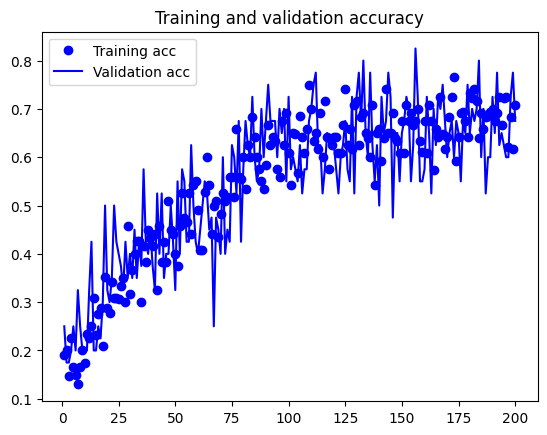

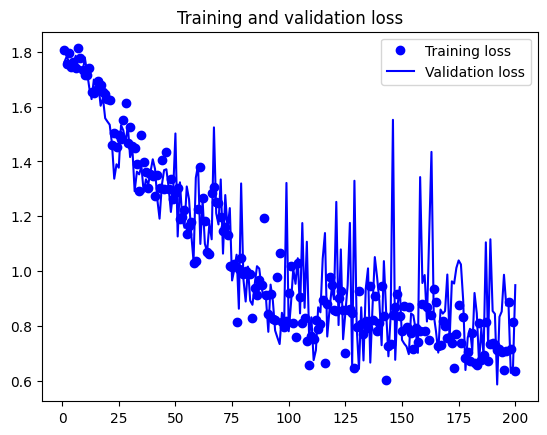

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
f1_score = classifier_history.history['f1_m']
val_f1_score = classifier_history.history['val_f1_m']

<Figure size 640x480 with 0 Axes>

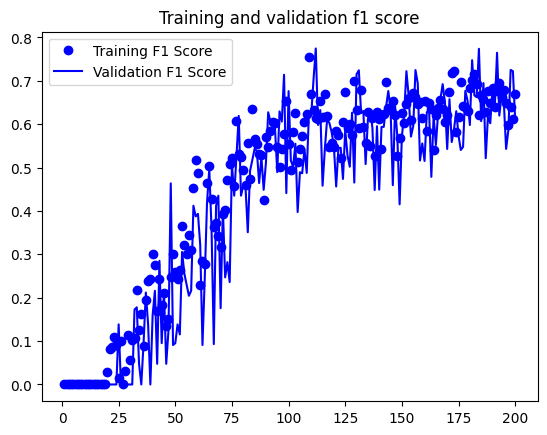

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, f1_score, 'bo', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1 Score')
plt.title('Training and validation f1 score')
plt.legend()

plt.figure()

In [ ]:
# Save history

import pickle
HISTORY_PATH = f"{ROOT_PATH}/Dataset/model_checkpoints/best_model5_simple_augmented/history"
with open(HISTORY_PATH, 'wb') as file_pi:
    pickle.dump(classifier_history.history, file_pi)

In [ ]:
with open(HISTORY_PATH, "rb") as file_pi:
    history = pickle.load(file_pi)

<Figure size 640x480 with 0 Axes>

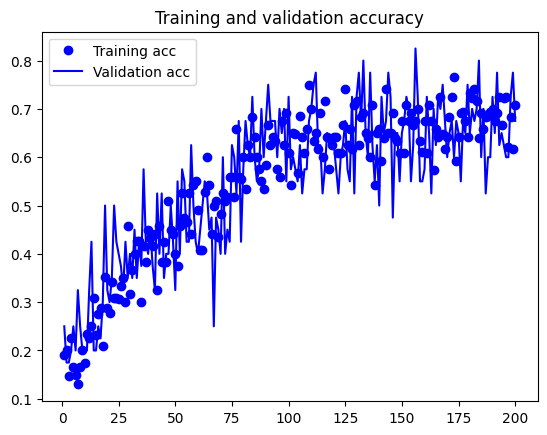

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history['acc']
val_acc = history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Load Model

In [ ]:
CHECKPOINT_PATH = f"{ROOT_PATH}/Dataset/model_checkpoints/best_model5_simple_augmented/best_model"
loaded_model = tf.keras.models.load_model(CHECKPOINT_PATH, custom_objects={'f1_m': f1_m})

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path=fn
  img=load_img(path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  pred = loaded_model.predict(images, batch_size=10)

  print(pred)